In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same')) 
    model.add(BatchNormalization())
    model.add(Activation('tanh'))    
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('tanh'))
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())   
        model.add(Activation('tanh'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 64)         256       
_________________________________________________________________
activation_1 (Activat

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_20 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_20 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_21 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_21 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_42 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_43 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_72 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_72 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         12352     
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.2561 - acc: 0.0985
Epoch 00001: val_loss improved from inf to 5.15518, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_BN_1_conv_checkpoint/001-5.1552.hdf5
36805/36805 [==============================] - 78s 2ms/sample - loss: 5.2559 - acc: 0.0985 - val_loss: 5.1552 - val_acc: 0.1006
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.0044 - acc: 0.3673
Epoch 00002: val_loss did not improve from 5.15518
36805/36805 [==============================] - 74s 2ms/sample - loss: 3.0044 - acc: 0.3673 - val_loss: 10.2006 - val_acc: 0.0869
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7335 - acc: 0.5844
Epoch 00003: val_loss did not improve from 5.15518
36805/36805 [==============================] - 74s 2ms/sample - loss: 1.7334 - acc: 0.5844 - val_loss

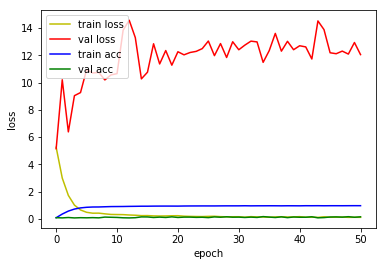

4815/4815 [==============================] - 3s 695us/sample - loss: 5.1162 - acc: 0.1032
Loss: 5.116166759898977 Accuracy: 0.10321911

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.1669 - acc: 0.2408
Epoch 00001: val_loss improved from inf to 2.90470, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_BN_2_conv_checkpoint/001-2.9047.hdf5
36805/36805 [==============================] - 136s 4ms/sample - loss: 3.1671 - acc: 0.2408 - val_loss: 2.9047 - val_acc: 0.3005
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6927 - acc: 0.5243
Epoch 00002: val_loss did not improve from 2.90470
36805/36805 [==============================] - 132s 4ms/sample - loss: 1.6928 - acc: 0.5242 - val_loss: 4.9845 - val_acc: 0.2667
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9511 - acc: 0.7148
Epoch 00003: val_loss did not improve from 2.90470
36805/36805 

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0899 - acc: 0.9774
Epoch 00030: val_loss did not improve from 2.90470
36805/36805 [==============================] - 132s 4ms/sample - loss: 0.0899 - acc: 0.9774 - val_loss: 10.3857 - val_acc: 0.1989
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1148 - acc: 0.9721
Epoch 00031: val_loss did not improve from 2.90470
36805/36805 [==============================] - 132s 4ms/sample - loss: 0.1148 - acc: 0.9721 - val_loss: 8.6010 - val_acc: 0.2751
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1003 - acc: 0.9743
Epoch 00032: val_loss did not improve from 2.90470
36805/36805 [==============================] - 132s 4ms/sample - loss: 0.1004 - acc: 0.9743 - val_loss: 7.1624 - val_acc: 0.3287
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0963 - acc: 0.9753
Epoch 00033: val_loss did not improve from 2.90470
36805/36805 [=======

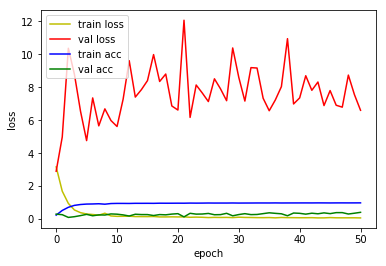

4815/4815 [==============================] - 6s 1ms/sample - loss: 3.0071 - acc: 0.2721
Loss: 3.007104391224783 Accuracy: 0.27206644

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4392 - acc: 0.3171
Epoch 00001: val_loss improved from inf to 5.79774, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_BN_3_conv_checkpoint/001-5.7977.hdf5
36805/36805 [==============================] - 157s 4ms/sample - loss: 2.4392 - acc: 0.3171 - val_loss: 5.7977 - val_acc: 0.1789
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5434 - acc: 0.5405
Epoch 00002: val_loss improved from 5.79774 to 5.51859, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_BN_3_conv_checkpoint/002-5.5186.hdf5
36805/36805 [==============================] - 151s 4ms/sample - loss: 1.5433 - acc: 0.5405 - val_loss: 5.5186 - val_acc: 0.1742
Epoch 3/500
36800/36805 [============================

36800/36805 [============================>.] - ETA: 0s - loss: 0.1080 - acc: 0.9664
Epoch 00028: val_loss did not improve from 3.03593
36805/36805 [==============================] - 151s 4ms/sample - loss: 0.1080 - acc: 0.9664 - val_loss: 4.4387 - val_acc: 0.4195
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1028 - acc: 0.9689
Epoch 00029: val_loss did not improve from 3.03593
36805/36805 [==============================] - 151s 4ms/sample - loss: 0.1028 - acc: 0.9689 - val_loss: 4.5849 - val_acc: 0.4179
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1074 - acc: 0.9678
Epoch 00030: val_loss did not improve from 3.03593
36805/36805 [==============================] - 151s 4ms/sample - loss: 0.1074 - acc: 0.9678 - val_loss: 6.2614 - val_acc: 0.3764
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1025 - acc: 0.9688
Epoch 00031: val_loss did not improve from 3.03593
36805/36805 [=====================

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0661 - acc: 0.9819
Epoch 00058: val_loss did not improve from 3.03593
36805/36805 [==============================] - 151s 4ms/sample - loss: 0.0661 - acc: 0.9819 - val_loss: 3.3177 - val_acc: 0.5504
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0708 - acc: 0.9799
Epoch 00059: val_loss did not improve from 3.03593
36805/36805 [==============================] - 151s 4ms/sample - loss: 0.0708 - acc: 0.9799 - val_loss: 4.9889 - val_acc: 0.4710
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0651 - acc: 0.9817
Epoch 00060: val_loss did not improve from 3.03593
36805/36805 [==============================] - 151s 4ms/sample - loss: 0.0651 - acc: 0.9817 - val_loss: 4.4916 - val_acc: 0.4938

1D_CNN_custom_conv_3_VGG_tanh_DO_BN_3_conv Model


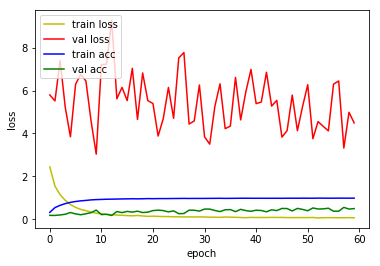

4815/4815 [==============================] - 7s 1ms/sample - loss: 3.2692 - acc: 0.3927
Loss: 3.2692273603421507 Accuracy: 0.39273104

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2276 - acc: 0.3401
Epoch 00001: val_loss improved from inf to 3.76052, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_BN_4_conv_checkpoint/001-3.7605.hdf5
36805/36805 [==============================] - 168s 5ms/sample - loss: 2.2277 - acc: 0.3400 - val_loss: 3.7605 - val_acc: 0.1975
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5040 - acc: 0.5427
Epoch 00002: val_loss improved from 3.76052 to 1.76325, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_BN_4_conv_checkpoint/002-1.7632.hdf5
36805/36805 [==============================] - 158s 4ms/sample - loss: 1.5040 - acc: 0.5426 - val_loss: 1.7632 - val_acc: 0.5059
Epoch 3/500
36800/36805 [===========================

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1863 - acc: 0.9402
Epoch 00029: val_loss did not improve from 1.47458
36805/36805 [==============================] - 158s 4ms/sample - loss: 0.1864 - acc: 0.9402 - val_loss: 2.8196 - val_acc: 0.5523
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2093 - acc: 0.9356
Epoch 00030: val_loss did not improve from 1.47458
36805/36805 [==============================] - 158s 4ms/sample - loss: 0.2094 - acc: 0.9356 - val_loss: 2.5997 - val_acc: 0.5225
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1733 - acc: 0.9453
Epoch 00031: val_loss did not improve from 1.47458
36805/36805 [==============================] - 158s 4ms/sample - loss: 0.1733 - acc: 0.9453 - val_loss: 2.8083 - val_acc: 0.4997
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1702 - acc: 0.9455
Epoch 00032: val_loss did not improve from 1.47458
36805/36805 [========

Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1011 - acc: 0.9680
Epoch 00059: val_loss did not improve from 1.47458
36805/36805 [==============================] - 158s 4ms/sample - loss: 0.1011 - acc: 0.9680 - val_loss: 3.0852 - val_acc: 0.5588
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1017 - acc: 0.9673
Epoch 00060: val_loss did not improve from 1.47458
36805/36805 [==============================] - 157s 4ms/sample - loss: 0.1017 - acc: 0.9673 - val_loss: 3.6497 - val_acc: 0.4889
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0950 - acc: 0.9699
Epoch 00061: val_loss did not improve from 1.47458
36805/36805 [==============================] - 158s 4ms/sample - loss: 0.0950 - acc: 0.9699 - val_loss: 2.0025 - val_acc: 0.6758
Epoch 62/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1046 - acc: 0.9659
Epoch 00062: val_loss did not improve from 1.47458
36805/36805 [========

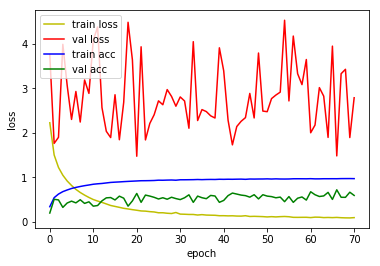

4815/4815 [==============================] - 7s 2ms/sample - loss: 1.6950 - acc: 0.5952
Loss: 1.6949939185585188 Accuracy: 0.59522325

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1294 - acc: 0.3591
Epoch 00001: val_loss improved from inf to 3.83865, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_BN_5_conv_checkpoint/001-3.8386.hdf5
36805/36805 [==============================] - 178s 5ms/sample - loss: 2.1294 - acc: 0.3591 - val_loss: 3.8386 - val_acc: 0.1912
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4692 - acc: 0.5500
Epoch 00002: val_loss improved from 3.83865 to 1.50158, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_BN_5_conv_checkpoint/002-1.5016.hdf5
36805/36805 [==============================] - 163s 4ms/sample - loss: 1.4691 - acc: 0.5500 - val_loss: 1.5016 - val_acc: 0.5756
Epoch 3/500
36800/36805 [===========================

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2448 - acc: 0.9229
Epoch 00029: val_loss improved from 1.43025 to 1.34834, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_BN_5_conv_checkpoint/029-1.3483.hdf5
36805/36805 [==============================] - 163s 4ms/sample - loss: 0.2448 - acc: 0.9229 - val_loss: 1.3483 - val_acc: 0.6699
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2461 - acc: 0.9225
Epoch 00030: val_loss did not improve from 1.34834
36805/36805 [==============================] - 163s 4ms/sample - loss: 0.2461 - acc: 0.9225 - val_loss: 1.6379 - val_acc: 0.6434
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2348 - acc: 0.9232
Epoch 00031: val_loss did not improve from 1.34834
36805/36805 [==============================] - 163s 4ms/sample - loss: 0.2349 - acc: 0.9232 - val_loss: 4.3900 - val_acc: 0.4563
Epoch 32/500
36800/36805 [============================>.] - E

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1308 - acc: 0.9574
Epoch 00058: val_loss did not improve from 1.27846
36805/36805 [==============================] - 163s 4ms/sample - loss: 0.1308 - acc: 0.9574 - val_loss: 3.6726 - val_acc: 0.4854
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1327 - acc: 0.9570
Epoch 00059: val_loss did not improve from 1.27846
36805/36805 [==============================] - 163s 4ms/sample - loss: 0.1327 - acc: 0.9570 - val_loss: 1.7685 - val_acc: 0.6653
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1339 - acc: 0.9591
Epoch 00060: val_loss did not improve from 1.27846
36805/36805 [==============================] - 163s 4ms/sample - loss: 0.1339 - acc: 0.9591 - val_loss: 1.7674 - val_acc: 0.6683
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1286 - acc: 0.9593
Epoch 00061: val_loss did not improve from 1.27846
36805/36805 [========

Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0928 - acc: 0.9709
Epoch 00088: val_loss did not improve from 1.27846
36805/36805 [==============================] - 163s 4ms/sample - loss: 0.0928 - acc: 0.9709 - val_loss: 1.9068 - val_acc: 0.6762
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0962 - acc: 0.9693
Epoch 00089: val_loss did not improve from 1.27846
36805/36805 [==============================] - 163s 4ms/sample - loss: 0.0962 - acc: 0.9693 - val_loss: 1.3974 - val_acc: 0.7349
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0974 - acc: 0.9706
Epoch 00090: val_loss did not improve from 1.27846
36805/36805 [==============================] - 163s 4ms/sample - loss: 0.0974 - acc: 0.9706 - val_loss: 1.4033 - val_acc: 0.7468
Epoch 91/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0960 - acc: 0.9702
Epoch 00091: val_loss did not improve from 1.27846
36805/36805 [========

Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0820 - acc: 0.9746
Epoch 00117: val_loss did not improve from 1.14935
36805/36805 [==============================] - 163s 4ms/sample - loss: 0.0820 - acc: 0.9747 - val_loss: 1.3045 - val_acc: 0.7666
Epoch 118/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0757 - acc: 0.9776
Epoch 00118: val_loss did not improve from 1.14935
36805/36805 [==============================] - 163s 4ms/sample - loss: 0.0757 - acc: 0.9776 - val_loss: 1.9810 - val_acc: 0.6897
Epoch 119/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0763 - acc: 0.9766
Epoch 00119: val_loss did not improve from 1.14935
36805/36805 [==============================] - 163s 4ms/sample - loss: 0.0763 - acc: 0.9766 - val_loss: 3.6130 - val_acc: 0.5842
Epoch 120/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0798 - acc: 0.9744
Epoch 00120: val_loss did not improve from 1.14935
36805/36805 [====

Epoch 147/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0616 - acc: 0.9816
Epoch 00147: val_loss did not improve from 1.14935
36805/36805 [==============================] - 163s 4ms/sample - loss: 0.0616 - acc: 0.9816 - val_loss: 1.6837 - val_acc: 0.7216
Epoch 148/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0682 - acc: 0.9794
Epoch 00148: val_loss did not improve from 1.14935
36805/36805 [==============================] - 163s 4ms/sample - loss: 0.0682 - acc: 0.9794 - val_loss: 2.2249 - val_acc: 0.6858
Epoch 149/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0656 - acc: 0.9806
Epoch 00149: val_loss did not improve from 1.14935
36805/36805 [==============================] - 163s 4ms/sample - loss: 0.0656 - acc: 0.9806 - val_loss: 1.8105 - val_acc: 0.7219
Epoch 150/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0736 - acc: 0.9775
Epoch 00150: val_loss did not improve from 1.14935
36805/36805 [====

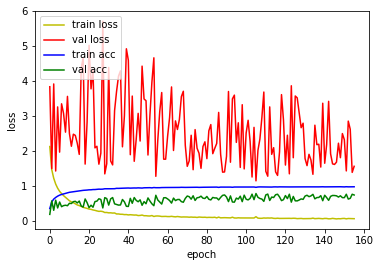

4815/4815 [==============================] - 8s 2ms/sample - loss: 1.3499 - acc: 0.7481
Loss: 1.3499332119742657 Accuracy: 0.74807894

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2138 - acc: 0.3299
Epoch 00001: val_loss improved from inf to 1.65098, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_BN_6_conv_checkpoint/001-1.6510.hdf5
36805/36805 [==============================] - 188s 5ms/sample - loss: 2.2137 - acc: 0.3300 - val_loss: 1.6510 - val_acc: 0.4617
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5767 - acc: 0.5095
Epoch 00002: val_loss did not improve from 1.65098
36805/36805 [==============================] - 166s 5ms/sample - loss: 1.5770 - acc: 0.5095 - val_loss: 2.7413 - val_acc: 0.3375
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3039 - acc: 0.5960
Epoch 00003: val_loss did not improve from 1.65098
36805/36805 [

36800/36805 [============================>.] - ETA: 0s - loss: 0.3916 - acc: 0.8805
Epoch 00028: val_loss did not improve from 0.80168
36805/36805 [==============================] - 166s 5ms/sample - loss: 0.3916 - acc: 0.8805 - val_loss: 1.0746 - val_acc: 0.7265
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3791 - acc: 0.8817
Epoch 00029: val_loss did not improve from 0.80168
36805/36805 [==============================] - 166s 5ms/sample - loss: 0.3790 - acc: 0.8817 - val_loss: 1.8903 - val_acc: 0.6191
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3667 - acc: 0.8880
Epoch 00030: val_loss did not improve from 0.80168
36805/36805 [==============================] - 166s 5ms/sample - loss: 0.3667 - acc: 0.8880 - val_loss: 2.1277 - val_acc: 0.5945
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3609 - acc: 0.8885
Epoch 00031: val_loss did not improve from 0.80168
36805/36805 [=====================

Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1245 - acc: 0.9600
Epoch 00087: val_loss did not improve from 0.77185
36805/36805 [==============================] - 166s 5ms/sample - loss: 0.1245 - acc: 0.9600 - val_loss: 2.0572 - val_acc: 0.6490
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1259 - acc: 0.9589
Epoch 00088: val_loss did not improve from 0.77185
36805/36805 [==============================] - 166s 5ms/sample - loss: 0.1259 - acc: 0.9589 - val_loss: 1.4689 - val_acc: 0.7018
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1187 - acc: 0.9622
Epoch 00089: val_loss did not improve from 0.77185
36805/36805 [==============================] - 166s 5ms/sample - loss: 0.1187 - acc: 0.9622 - val_loss: 1.4581 - val_acc: 0.7135
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1201 - acc: 0.9606
Epoch 00090: val_loss did not improve from 0.77185
36805/36805 [========

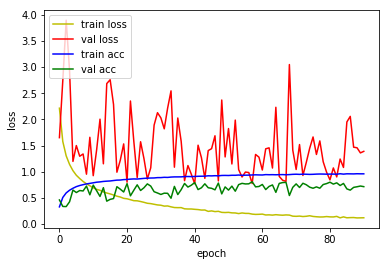

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.8908 - acc: 0.7666
Loss: 0.8907650150861571 Accuracy: 0.7665628

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3231 - acc: 0.2915
Epoch 00001: val_loss improved from inf to 1.89036, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_BN_7_conv_checkpoint/001-1.8904.hdf5
36805/36805 [==============================] - 200s 5ms/sample - loss: 2.3230 - acc: 0.2915 - val_loss: 1.8904 - val_acc: 0.4267
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6374 - acc: 0.4858
Epoch 00002: val_loss did not improve from 1.89036
36805/36805 [==============================] - 168s 5ms/sample - loss: 1.6374 - acc: 0.4858 - val_loss: 1.9912 - val_acc: 0.4344
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3596 - acc: 0.5729
Epoch 00003: val_loss did not improve from 1.89036
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 0.2963 - acc: 0.9110
Epoch 00028: val_loss did not improve from 0.57349
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.2963 - acc: 0.9110 - val_loss: 0.9123 - val_acc: 0.7803
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2918 - acc: 0.9136
Epoch 00029: val_loss did not improve from 0.57349
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.2919 - acc: 0.9135 - val_loss: 2.7934 - val_acc: 0.5402
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2828 - acc: 0.9149
Epoch 00030: val_loss did not improve from 0.57349
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.2828 - acc: 0.9149 - val_loss: 0.6143 - val_acc: 0.8379
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2682 - acc: 0.9200
Epoch 00031: val_loss improved from 0.57349 to 0.49098, saving model to model/checkpo

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1276 - acc: 0.9610
Epoch 00057: val_loss did not improve from 0.44837
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.1278 - acc: 0.9609 - val_loss: 0.6613 - val_acc: 0.8330
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1366 - acc: 0.9564
Epoch 00058: val_loss did not improve from 0.44837
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.1366 - acc: 0.9564 - val_loss: 0.4810 - val_acc: 0.8798
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1197 - acc: 0.9637
Epoch 00059: val_loss did not improve from 0.44837
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.1197 - acc: 0.9637 - val_loss: 0.8349 - val_acc: 0.8134
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1194 - acc: 0.9628
Epoch 00060: val_loss did not improve from 0.44837
36805/36805 [========

Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0518 - acc: 0.9845
Epoch 00116: val_loss did not improve from 0.41917
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0518 - acc: 0.9845 - val_loss: 0.6638 - val_acc: 0.8626
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0511 - acc: 0.9846
Epoch 00117: val_loss did not improve from 0.41917
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0511 - acc: 0.9846 - val_loss: 0.8220 - val_acc: 0.8341
Epoch 118/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0513 - acc: 0.9852
Epoch 00118: val_loss did not improve from 0.41917
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0514 - acc: 0.9852 - val_loss: 0.7925 - val_acc: 0.8425
Epoch 119/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0552 - acc: 0.9838
Epoch 00119: val_loss did not improve from 0.41917
36805/36805 [====

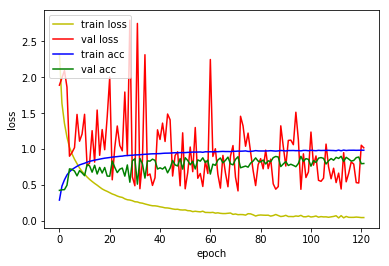

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.5582 - acc: 0.8681
Loss: 0.5582438387479614 Accuracy: 0.86812043

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3372 - acc: 0.2896
Epoch 00001: val_loss improved from inf to 1.80493, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_BN_8_conv_checkpoint/001-1.8049.hdf5
36805/36805 [==============================] - 212s 6ms/sample - loss: 2.3371 - acc: 0.2896 - val_loss: 1.8049 - val_acc: 0.4335
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6240 - acc: 0.4913
Epoch 00002: val_loss improved from 1.80493 to 1.44399, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_BN_8_conv_checkpoint/002-1.4440.hdf5
36805/36805 [==============================] - 170s 5ms/sample - loss: 1.6240 - acc: 0.4913 - val_loss: 1.4440 - val_acc: 0.5618
Epoch 3/500
36800/36805 [===========================

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1971 - acc: 0.9419
Epoch 00026: val_loss did not improve from 0.28532
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.1971 - acc: 0.9419 - val_loss: 0.4688 - val_acc: 0.8730
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1878 - acc: 0.9448
Epoch 00027: val_loss improved from 0.28532 to 0.27237, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_BN_8_conv_checkpoint/027-0.2724.hdf5
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.1878 - acc: 0.9448 - val_loss: 0.2724 - val_acc: 0.9229
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1807 - acc: 0.9466
Epoch 00028: val_loss did not improve from 0.27237
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.1807 - acc: 0.9466 - val_loss: 0.3137 - val_acc: 0.9082
Epoch 29/500
36800/36805 [============================>.] - E

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0632 - acc: 0.9810
Epoch 00054: val_loss did not improve from 0.22873
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0632 - acc: 0.9810 - val_loss: 0.3143 - val_acc: 0.9129
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0661 - acc: 0.9799
Epoch 00055: val_loss did not improve from 0.22873
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0662 - acc: 0.9799 - val_loss: 0.2521 - val_acc: 0.9350
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0683 - acc: 0.9800
Epoch 00056: val_loss did not improve from 0.22873
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0683 - acc: 0.9800 - val_loss: 0.3929 - val_acc: 0.9026
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0638 - acc: 0.9805
Epoch 00057: val_loss did not improve from 0.22873
36805/36805 [========

Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0222 - acc: 0.9933
Epoch 00113: val_loss did not improve from 0.18500
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0222 - acc: 0.9933 - val_loss: 0.3165 - val_acc: 0.9257
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0193 - acc: 0.9946
Epoch 00114: val_loss did not improve from 0.18500
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0193 - acc: 0.9946 - val_loss: 0.3633 - val_acc: 0.9206
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0326 - acc: 0.9900
Epoch 00115: val_loss did not improve from 0.18500
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0326 - acc: 0.9900 - val_loss: 0.7131 - val_acc: 0.8472
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0232 - acc: 0.9930
Epoch 00116: val_loss did not improve from 0.18500
36805/36805 [====

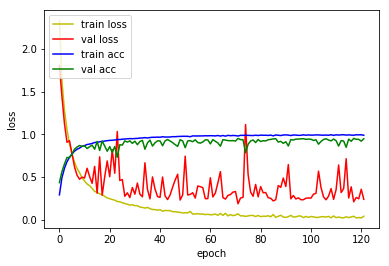

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2550 - acc: 0.9364
Loss: 0.25499458150824034 Accuracy: 0.9364486

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0621 - acc: 0.3744
Epoch 00001: val_loss improved from inf to 1.80081, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_BN_9_conv_checkpoint/001-1.8008.hdf5
36805/36805 [==============================] - 228s 6ms/sample - loss: 2.0623 - acc: 0.3744 - val_loss: 1.8008 - val_acc: 0.4561
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2209 - acc: 0.6198
Epoch 00002: val_loss improved from 1.80081 to 1.18811, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_BN_9_conv_checkpoint/002-1.1881.hdf5
36805/36805 [==============================] - 172s 5ms/sample - loss: 1.2209 - acc: 0.6198 - val_loss: 1.1881 - val_acc: 0.6245
Epoch 3/500
36800/36805 [===========================

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0810 - acc: 0.9742
Epoch 00025: val_loss did not improve from 0.20083
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.0810 - acc: 0.9742 - val_loss: 0.5960 - val_acc: 0.8288
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0804 - acc: 0.9758
Epoch 00026: val_loss did not improve from 0.20083
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.0804 - acc: 0.9758 - val_loss: 0.2510 - val_acc: 0.9327
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0776 - acc: 0.9762
Epoch 00027: val_loss did not improve from 0.20083
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.0776 - acc: 0.9763 - val_loss: 0.4670 - val_acc: 0.8668
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0763 - acc: 0.9767
Epoch 00028: val_loss did not improve from 0.20083
36805/36805 [========

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0112 - acc: 0.9968
Epoch 00083: val_loss did not improve from 0.16404
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.0112 - acc: 0.9968 - val_loss: 0.2481 - val_acc: 0.9467
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0242 - acc: 0.9921
Epoch 00084: val_loss did not improve from 0.16404
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.0242 - acc: 0.9920 - val_loss: 0.1875 - val_acc: 0.9571
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0259 - acc: 0.9916
Epoch 00085: val_loss did not improve from 0.16404
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.0259 - acc: 0.9916 - val_loss: 0.2155 - val_acc: 0.9504
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0120 - acc: 0.9966
Epoch 00086: val_loss did not improve from 0.16404
36805/36805 [========

Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0249 - acc: 0.9921
Epoch 00113: val_loss did not improve from 0.16404
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.0249 - acc: 0.9921 - val_loss: 0.2039 - val_acc: 0.9555
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0059 - acc: 0.9986
Epoch 00114: val_loss did not improve from 0.16404
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.0059 - acc: 0.9986 - val_loss: 0.1816 - val_acc: 0.9588
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0129 - acc: 0.9959
Epoch 00115: val_loss did not improve from 0.16404
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.0130 - acc: 0.9959 - val_loss: 0.2598 - val_acc: 0.9448
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0283 - acc: 0.9916
Epoch 00116: val_loss did not improve from 0.16404
36805/36805 [====

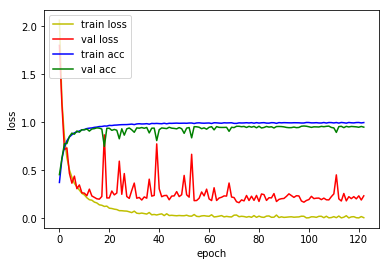

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2268 - acc: 0.9439
Loss: 0.22682350990889538 Accuracy: 0.94392526



In [10]:
base = '1D_CNN_custom_conv_3_VGG_tanh_DO_BN'

for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [8]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_tanh_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_tanh_DO_BN_1_conv Model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_90 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_91 (B (None, 16000, 64)         

4815/4815 [==============================] - 7s 1ms/sample - loss: 3.2692 - acc: 0.3927
Loss: 3.2692273603421507 Accuracy: 0.39273104

1D_CNN_custom_conv_3_VGG_tanh_DO_BN_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_102 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_102 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_102 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_103 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_103 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_103 (Activati

4815/4815 [==============================] - 7s 2ms/sample - loss: 1.3499 - acc: 0.7481
Loss: 1.3499332119742657 Accuracy: 0.74807894

1D_CNN_custom_conv_3_VGG_tanh_DO_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_120 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_120 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_120 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_121 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_121 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_121 (Activati

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.5582 - acc: 0.8681
Loss: 0.5582438387479614 Accuracy: 0.86812043

1D_CNN_custom_conv_3_VGG_tanh_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_146 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_146 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_146 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_147 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_147 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_147 (Activati

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.2550 - acc: 0.9364
Loss: 0.25499458150824034 Accuracy: 0.9364486

1D_CNN_custom_conv_3_VGG_tanh_DO_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_162 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_162 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_162 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_163 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_163 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_163 (Activati

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2268 - acc: 0.9439
Loss: 0.22682350990889538 Accuracy: 0.94392526


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_tanh_DO_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_90 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_91 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_91 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)       

4815/4815 [==============================] - 10s 2ms/sample - loss: 3.2771 - acc: 0.5379
Loss: 3.2771400493253426 Accuracy: 0.5379024

1D_CNN_custom_conv_3_VGG_tanh_DO_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_110 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_110 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_110 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_111 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_111 (Activati

4815/4815 [==============================] - 10s 2ms/sample - loss: 1.6797 - acc: 0.6746
Loss: 1.679700240489726 Accuracy: 0.6745587

1D_CNN_custom_conv_3_VGG_tanh_DO_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_132 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_132 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_132 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_133 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_133 (Activatio

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.2789 - acc: 0.9367
Loss: 0.278882783901252 Accuracy: 0.9366563

1D_CNN_custom_conv_3_VGG_tanh_DO_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_162 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_162 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_162 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_163 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_163 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_163 (Activatio

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.3472 - acc: 0.9263
Loss: 0.3472443039914901 Accuracy: 0.9262721
